# _Forecasting Covid-19 Worldwide Cases with ARIMA-Artificial Neural Network and Facebook Prophet_

### Import Library

In [14]:
import numpy as np
import pandas as pd

import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense,Activation

from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

import datetime as dt
import time

from keras import backend as K
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [36]:
# setting datetime as format dd-mm-yy
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y') 

# read csv data
df = pd.read_csv('COVID-19-geographic-disbtribution-worldwide.csv', sep=';', parse_dates=['dateRep'], date_parser=dateparse)

# sorting dateRep from oldest to newest
tdf = df.sort_values(by="dateRep")

In [37]:
tdf

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
8115 2019-12-31   31     12  2019      0       0                  Sweden   
4007 2019-12-31   31     12  2019      0       0               Indonesia   
7886 2019-12-31   31     12  2019      0       0                   Spain   
609  2019-12-31   31     12  2019      0       0                 Austria   
2058 2019-12-31   31     12  2019      0       0                 Croatia   
...         ...  ...    ...   ...    ...     ...                     ...   
6653 2020-04-06    6      4  2020      0       0        Papua_New_Guinea   
6670 2020-04-06    6      4  2020      9       2                Paraguay   
8432 2020-04-06    6      4  2020      3       0                    Togo   
4838 2020-04-06    6      4  2020     72       3              Kyrgyzstan   
0    2020-04-06    6      4  2020     29       2             Afghanistan   

     geoId countryterritoryCode  popData2018  
8115    SE                  SWE   10183175.0  
4007    ID                  IDN  267663435.0  
7886    ES                  ESP   46723749.0  
609     AT                  AUT    8847037.0  
2058    HR                  HRV    4089400.0  
...    ...                  ...          ...  
6653    PG                  PNG    8606316.0  
6670    PY                  PRY    6956071.0  
8432    TG                  TGO    7889094.0  
4838    KG                  KGZ    6315800.0  
0       AF                  AFG   37172386.0  

[9107 rows x 10 columns]

## _Preprocessing_

### Data Cleaning

In [38]:
#dealing with missing data
#Let’s get rid of variables that we didn't use
tdf = tdf.drop(['geoId'], axis= 1)
tdf = tdf.drop(['countryterritoryCode'], axis= 1)
tdf = tdf.drop(['popData2018'], axis= 1)

tdf.isnull().sum().max() #just checking that there's no missing data missing...
tdf.head(5)

dateRep  day  month  year  cases  deaths countriesAndTerritories
8115 2019-12-31   31     12  2019      0       0                  Sweden
4007 2019-12-31   31     12  2019      0       0               Indonesia
7886 2019-12-31   31     12  2019      0       0                   Spain
609  2019-12-31   31     12  2019      0       0                 Austria
2058 2019-12-31   31     12  2019      0       0                 Croatia

In [39]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data type
intFeatures = ['dateRep','day','month','year','cases','deaths']
stringFeatures = ['countriesAndTerritories']
floatFeatures = []

# Clean the NaN's
for feature in tdf:
    if feature in intFeatures:
        tdf[feature] = tdf[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        tdf[feature] = tdf[feature].fillna(defaultString)
    elif feature in floatFeatures:
        tdf[feature] = tdf[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
tdf.head(5)   

dateRep  day  month  year  cases  deaths countriesAndTerritories
8115 2019-12-31   31     12  2019      0       0                  Sweden
4007 2019-12-31   31     12  2019      0       0               Indonesia
7886 2019-12-31   31     12  2019      0       0                   Spain
609  2019-12-31   31     12  2019      0       0                 Austria
2058 2019-12-31   31     12  2019      0       0                 Croatia

### Data Information

In [40]:
cx =tdf.groupby(["dateRep"]).agg({"cases":'sum',"deaths":'sum'})

In [41]:
print("total of countries that have covid-19 cases : ",len(tdf["countriesAndTerritories"].unique()))
print("total of confirmed covid-19 cases : ",cx["cases"].iloc[-1])
print("total of deaths covid-19 cases : ",cx["deaths"].iloc[-1])

total of countries that have covid-19 cases :  205
total of confirmed covid-19 cases :  69769
total of deaths covid-19 cases :  4576


In [42]:
print("total of confirmed covid-19 cases day by day : ",np.round(cx["cases"].iloc[-1]/cx.shape[0]))
print("total of deaths covid-19 deaths day by day : ",np.round(cx["deaths"].iloc[-1]/cx.shape[0]))

total of confirmed covid-19 cases day by day :  712.0
total of deaths covid-19 deaths day by day :  47.0


### Data Visualization (before encoding)

In [43]:
mix =tdf[tdf["dateRep"]==tdf["dateRep"].max()].groupby(["countriesAndTerritories"]).agg({"cases":'sum',"deaths":'sum'}).sort_values(["cases"],ascending=True)

Text(0.5, 1.0, '20 countries with the most covid-19 cases')

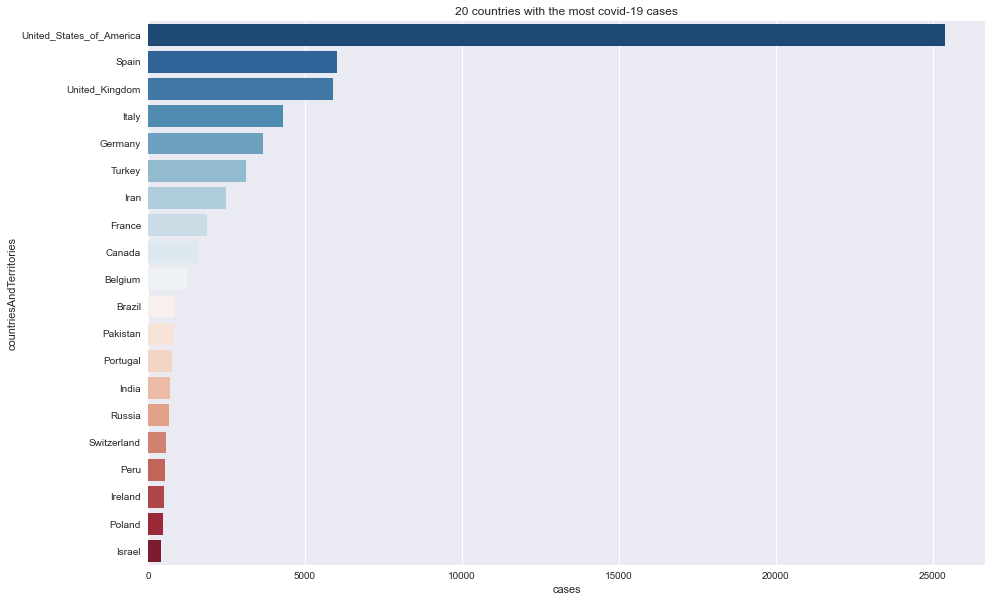

In [44]:
fig, (ax1) = plt.subplots(figsize=(15,10))
df =mix.sort_values(["cases"],ascending=False).head(20)
sns.barplot(x=df["cases"],y=df.index,ax=ax1,palette="RdBu_r")
ax1.set_title("20 countries with the most covid-19 cases")

Text(0.5, 1.0, '20 countries with the most covid-19 deaths')

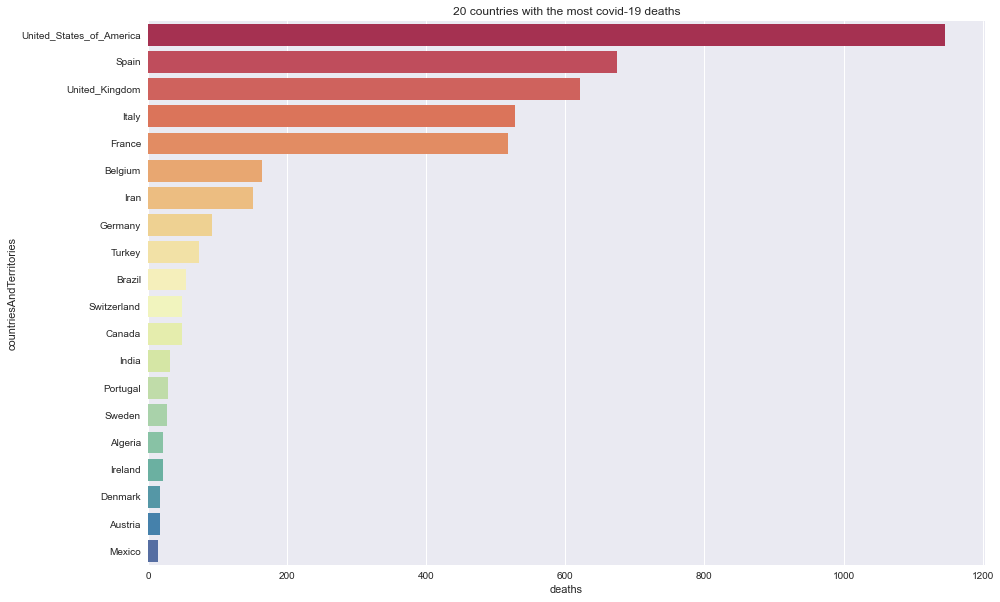

In [61]:
fig, (ax1) = plt.subplots(figsize=(15,10))
ddf =mix.sort_values(["deaths"],ascending=False).head(20)
sns.barplot(x=ddf["deaths"],y=ddf.index,ax=ax1,palette="Spectral")
ax1.set_title("20 countries with the most covid-19 deaths")

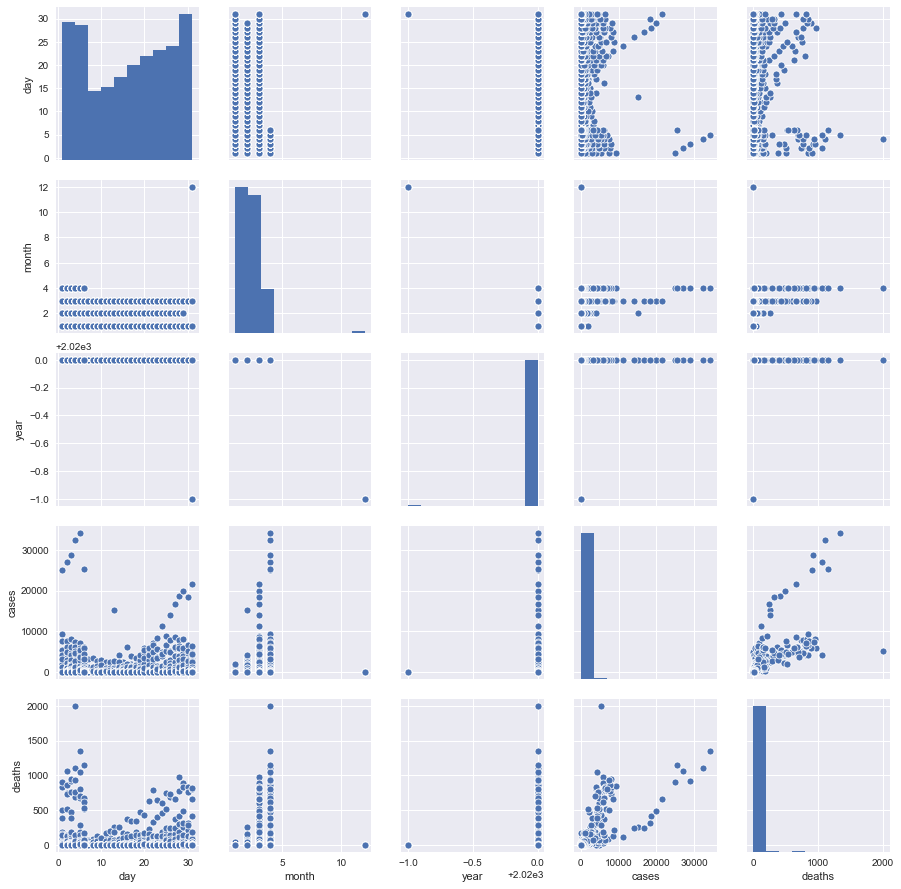

In [26]:
sns.pairplot(tdf);

### Encoding Data

In [35]:
# Set 'dateRep' as index
tdf.set_index("dateRep" , inplace = True)

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 
tdf['countriesAndTerritories']= label_encoder.fit_transform(tdf['countriesAndTerritories'])
tdf['countriesAndTerritories'].unique() 

tdf

day  month  year  cases  deaths  countriesAndTerritories
dateRep                                                             
2019-12-31   31     12  2019      0       0                      181
2019-12-31   31     12  2019      0       0                       92
2019-12-31   31     12  2019      0       0                      177
2019-12-31   31     12  2019      0       0                       11
2019-12-31   31     12  2019      0       0                       47
...         ...    ...   ...    ...     ...                      ...
2020-04-06    6      4  2020      0       0                      148
2020-04-06    6      4  2020      9       2                      149
2020-04-06    6      4  2020      3       0                      187
2020-04-06    6      4  2020     72       3                      107
2020-04-06    6      4  2020     29       2                        0

[9107 rows x 6 columns]

### Data Visualization (after encoding)

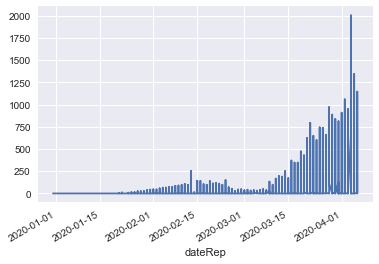

In [10]:
tdf['deaths'].plot()

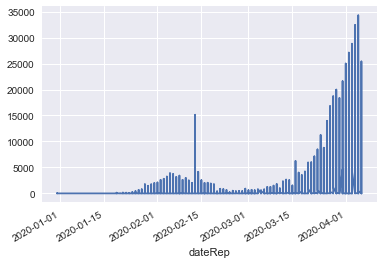

In [11]:
tdf['cases'].plot()

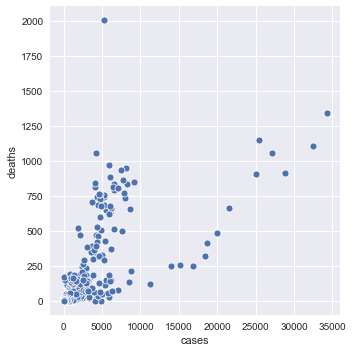

In [12]:
sns.relplot(x="cases", y="deaths", data=tdf);

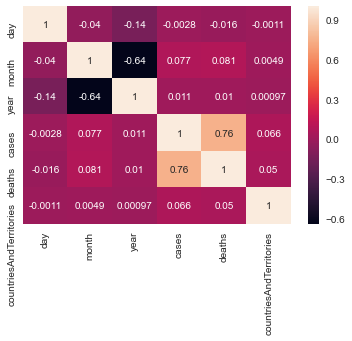

In [13]:
sns.heatmap(tdf.corr(),annot=True)

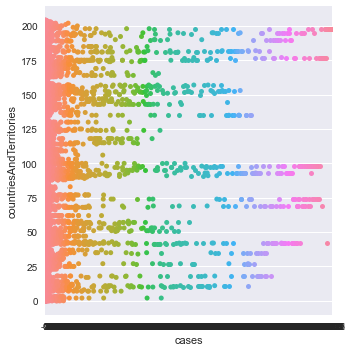

In [14]:
sns.catplot(x="cases",y="countriesAndTerritories",data=tdf)

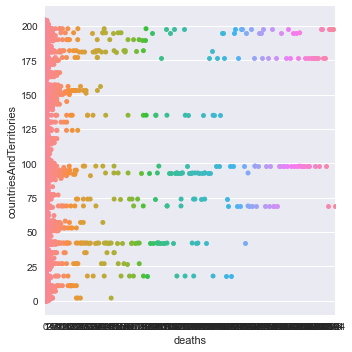

In [15]:
sns.catplot(x="deaths",y="countriesAndTerritories",data=tdf)

## _Forecasting_

### 1. ARIMA Model

In [16]:
tdf.index = pd.DatetimeIndex(tdf.index)

In [17]:
aggregate_data = tdf.pivot_table(index = tdf.index.date)
aggregate_data.head()

cases  countriesAndTerritories  day  deaths  month  year
2019-12-31  0.402985                101.41791   31     0.0     12  2019
2020-01-01  0.000000                101.41791    1     0.0      1  2020
2020-01-02  0.000000                101.41791    2     0.0      1  2020
2020-01-03  0.253731                101.41791    3     0.0      1  2020
2020-01-04  0.000000                101.41791    4     0.0      1  2020

In [18]:
column_list = aggregate_data["cases"].values.tolist()

training_len = int(len(column_list)*0.7)

train,test = column_list[:training_len] , column_list[training_len:]

In [19]:
training_data = train[:]
error_list = []
prediction_list = []

In [20]:
for i in test:
    model = ARIMA(training_data , order=(7,0,0))
    model_fit = model.fit(disp=0)
    predicted_value = model_fit.forecast()
    predicted_value = predicted_value[0]
    error = abs(predicted_value-i)
    prediction_list.append(predicted_value)
    error_list.append(error)
    training_data.append(i)
    print('predicted=%f, expected=%f error=%f' % (predicted_value , i ,error))

predicted=46.544452, expected=63.637931 error=17.093479
predicted=50.778735, expected=62.435484 error=11.656749
predicted=52.595740, expected=73.177419 error=20.581680
predicted=57.111412, expected=58.373333 error=1.261922
predicted=55.279541, expected=77.382022 error=22.102482
predicted=62.080695, expected=91.813187 error=29.732492
predicted=69.336003, expected=98.684211 error=29.348207
predicted=78.503107, expected=67.272727 error=11.230380
predicted=70.570420, expected=125.398438 error=54.828017
predicted=90.443938, expected=91.869565 error=1.425628
predicted=88.887776, expected=103.802817 error=14.915041
predicted=94.248871, expected=122.912752 error=28.663881
predicted=100.661029, expected=179.226994 error=78.565964
predicted=129.567201, expected=168.081871 error=38.514670
predicted=148.246188, expected=194.348571 error=46.102384
predicted=168.427804, expected=184.446927 error=16.019123
predicted=180.699226, expected=216.222826 error=35.523600
predicted=201.138684, expected=208.16

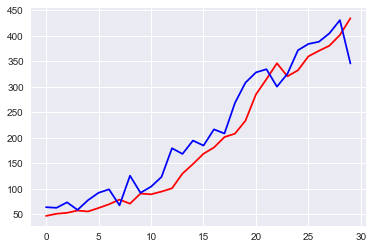

In [21]:
plt.plot(prediction_list,color='r')
plt.plot(test,color='b')

In [22]:
error_list = np.array(error_list)
mean_squared_error(test ,prediction_list)

1464.544779154151

In [23]:
model = ARIMA(train,order=(7,0,0))
model_fit_train = model.fit(disp=0)
training_error = model_fit_train.resid

training_error

array([-23.68745464, -12.08617725,  -9.06428607,  -7.11890335,
        -6.70938807,  -5.75202053,  -5.8428138 ,  -5.90974764,
        -5.92744209,  -5.89533785,  -5.88805291,  -5.88018022,
        -5.86649203,  -5.85715049,  -5.87664593,  -5.8592684 ,
        -5.87865171,  -5.80050538,  -5.64468766,  -3.93198455,
        -6.24224549,  -4.00726224,  -4.79005475,  -5.59303314,
        -3.18118034,  -1.05725578,   1.02357791,   1.07743057,
        14.11109971,   4.28407737,   6.81939816,   7.42521774,
         6.88983748,  11.40382637,  11.25457515,  15.24385664,
        21.05538784,  13.7085139 ,   3.31345293,   7.15990145,
        -5.89255545,   2.97830801,  -3.19609577,  -6.83808512,
       191.44882447, -29.09627075, -30.15455927, -31.01762113,
       -16.3514728 , -21.90625046, -11.96761698, -17.29460947,
        -6.35586349,  -4.25640782,  -3.99022805, -10.48823707,
        -2.74607745,  -1.84637989,   1.05537648,   2.31181272,
        10.04220852,   6.11319775,   7.33173866,  14.14

### 2. Artificial Neural Network

In [24]:
train_x = []
train_y = []
for i in range(len(training_error)-7):
    train_x.append(training_error[i:i+7])
    train_y.append(training_error[i+7])

In [25]:
test_x = []
test_y = []
for i in range(len(error_list)-7):
    test_x.append(error_list[i:i+7])
    test_y.append(error_list[i+7])

In [26]:
new_train_x = []
new_train_y = []

In [27]:
for i in train_x:
    new_train_x.append(i.reshape(-1))
    
for i in train_y:
    new_train_y.append(i.reshape(-1))
new_train_x = np.array(new_train_x)
new_train_y = np.array(new_train_y)

In [28]:
model = Sequential()
model.add(Dense(100 , activation="tanh" , init="uniform" , input_dim=7))
model.add(Dense(50 , activation="tanh" , init="uniform"))
model.add(Dense(25 , activation="tanh" , init="uniform"))
model.add(Dense(1 , activation="linear"))
model.compile("Adam", loss="mean_squared_error")

In [29]:
model.fit(new_train_x , new_train_y , batch_size=32, epochs=300,verbose=0)

In [30]:
new_test_x = []
new_test_y = []
for i in test_x:
    new_test_x.append(i.reshape(-1))
    
for i in test_y:
    new_test_y.append(i.reshape(-1))
new_test_x = np.array(new_test_x)
new_test_y = np.array(new_test_y)

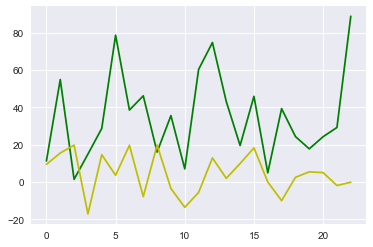

In [31]:
predict_error = model.predict(new_test_x)

plt.plot(test_y, color="g")
plt.plot(predict_error, color="y")

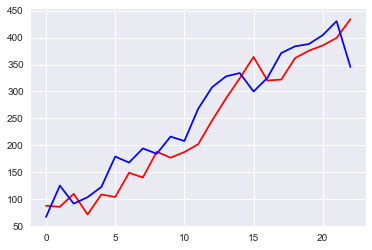

In [32]:
arima_ann_predict = prediction_list[7:]+predict_error

plt.plot(arima_ann_predict,color='r')
plt.plot(test[7:],color='b')

### 3. Facebook Prophet

In [33]:
tm_df = tdf.reset_index()

START_DATE = '2019-12-31'
n_train = 9107
n_test = 120

In [34]:
tm_df = tm_df[['dateRep','cases']]
tm_df.columns = ["ds", "y"]
tm_df

ds   y
0    2019-12-31   0
1    2019-12-31   0
2    2019-12-31   0
3    2019-12-31   0
4    2019-12-31   0
...         ...  ..
9102 2020-04-06   0
9103 2020-04-06   9
9104 2020-04-06   3
9105 2020-04-06  72
9106 2020-04-06  29

[9107 rows x 2 columns]

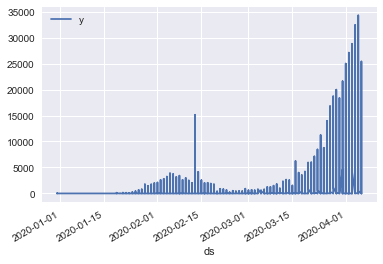

In [35]:
tm_df.iloc[:n_train].plot(x = "ds", y = "y")

In [36]:
m = Prophet()
m.fit(tm_df.iloc[:n_train])

future = m.make_future_dataframe(periods=n_test)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
9222 2020-07-31
9223 2020-08-01
9224 2020-08-02
9225 2020-08-03
9226 2020-08-04

In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat  yhat_lower   yhat_upper
9222 2020-07-31  2245.545508  994.422676  3708.622550
9223 2020-08-01  2258.191607  862.153197  3696.078550
9224 2020-08-02  2270.805155  962.972997  3855.013849
9225 2020-08-03  2265.005527  821.146360  3716.065453
9226 2020-08-04  2292.765592  868.204229  3793.157871

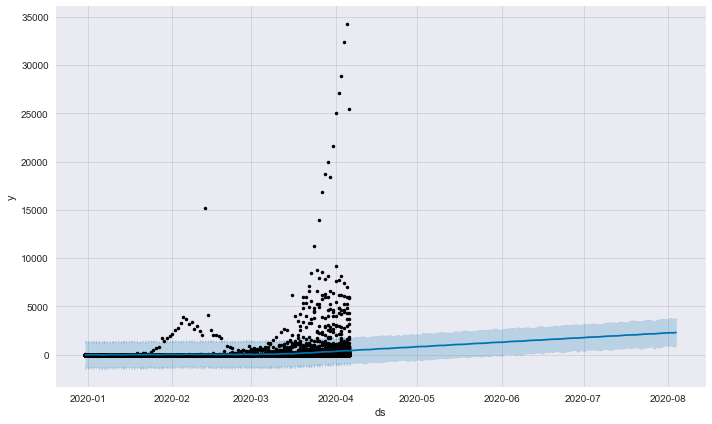

In [38]:
fig1 = m.plot(forecast)

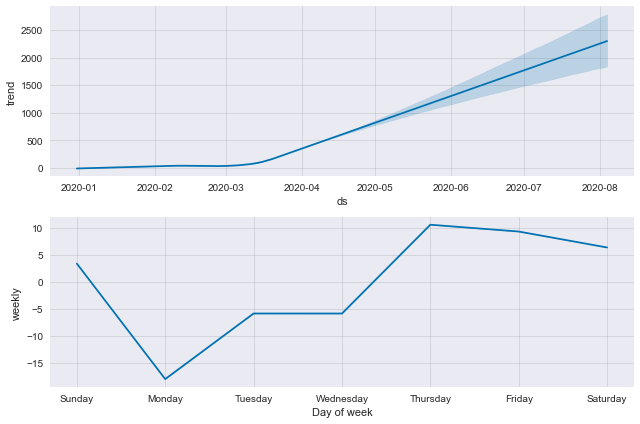

In [39]:
fig2 = m.plot_components(forecast)

In [40]:
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

source :

dataset : https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.csv
    
https://github.com/raginisharma96/rain_prediction
    
https://www.kaggle.com/ryches/forecasting-fraud-with-prophet